# Examen Transversal

---



**Autor:** Elías Antican

**Correo Electrónico:** el.antican@duocuc.cl

**Fecha de Creación:** Junio 2025

**Versión:** 1.0  



---

## Descripción

Este notebook corresponde al desarrollo de la entrega 2 de la asignatura electiva de Machine Learning de DuocUC - Sede Concepción

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- numpy (2.0.2)
- matplotlib (3.10.0)
- pandas (2.2.2)
- seaborn (0.13.2)
- sklearn (1.6.1)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import pandas as pd
print(pd.__version__)
````

# Fase 0 - Cargar de los datos

In [78]:
!wget https://www.dropbox.com/s/h160fwrthtb4gte/Base_Clientes_Monopoly.csv

--2025-07-02 03:55:02--  https://www.dropbox.com/s/h160fwrthtb4gte/Base_Clientes_Monopoly.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mz5u7ddatqayntt2crleq/Base_Clientes_Monopoly.csv?rlkey=nyn3hzxxby855id3gxxlbdev6 [following]
--2025-07-02 03:55:02--  https://www.dropbox.com/scl/fi/mz5u7ddatqayntt2crleq/Base_Clientes_Monopoly.csv?rlkey=nyn3hzxxby855id3gxxlbdev6
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca9b5d522772da3bcf44162602b.dl.dropboxusercontent.com/cd/0/inline/Csur67IEbIYuVjA8mBmfsa-tQzD8UTRcHpBq3g8n22iO1hUWnyxG1agXObK7wGBOnRjKFGa0n4dlSfLQwzpdyNE__kD7bdnuqm1Oe9itTmq7Rp3fnkTCngrlWotc-o_gKSCzJyGLscu_0WypwYZCYvsw/file# [following]
--2025-07-02 03:55:03--  https://uca9b5d522772da3bcf4416260

In [79]:
!pip install kneed
!pip install ydata-profiling

In [80]:
#Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

from kneed import KneeLocator

from ydata_profiling import ProfileReport

from scipy.stats import zscore

In [81]:
df = pd.read_csv("Base_Clientes_Monopoly.csv", sep=";", decimal=",", low_memory = False)

# Fase 1 - Comprensión del negocio

El siguiente análisis tiene los siguientes propósitos:


1.   Segmentar clientes
2.   Ofrecer créditos según segmentos
3.   Ofrecer inversiones según segmentos
4.   Gestionar riesgos
5.   Predecir comportamiento financiero

Se escogeran variables con el objetivo de realizar un análisis que le ayude al banco a tener una base sólida para una correcta toma de decisiones comerciales, de riesgo y de marketing.

#Fase 2 - Comprensión de los datos

Se procederá a realizar un informe centrado en las variables más relevantes según el objetivo del análisis.

**Fac_T12:** fue seleccionada como variable objetivo (target) en los modelos de regresión. Representa una variable que se quiere predecir, por eso, conocer su comportamiento es relevante.

**target:** se utilizó como la variable dependiente en los modelos de clasificación. Al ser una variable binaria, su análisis es fundamental para balancear clases y preparar el modelo para decisiones adecuadas.

**Edad y CUPO_MX:** fueron seleccionadas como variables relevantes para los modelos no supervisados. Se eligieron por su potencial para generar grupos significantes en relación al banco.

In [82]:
profile = ProfileReport(df[['Fac_T12', 'target', 'Edad', 'CUPO_MX']], title="Reporte personalizado", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00,  7.40it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

En el reporte se aprecia que las variables, en su mayoria, no tienen missing values.

**Fac_T12**, que tiene 8251, o un 16,1%.

**target**, que tiene 0.

**Edad** también con 0.

**CUPO_MX** con 0.

A continuación se van a apreciar los datos atípicos de las variables, usando gráficos de caja.

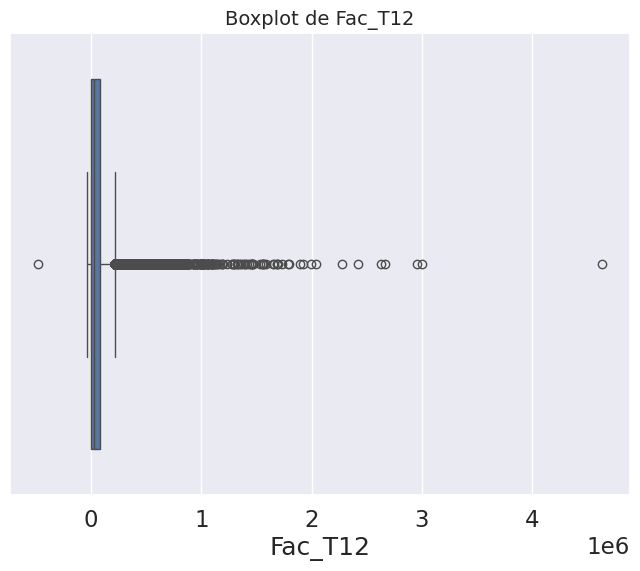

In [83]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['Fac_T12'])
plt.title('Boxplot de Fac_T12', fontsize=14)
plt.show()

Aquí se aprecia que a ambos lados hay valores atípicos, tanto unos muy mayores de 4.631.740, como se aprecia en el reporte. Y un valor, incluso, debajo de 0, que es -480.000, como se aprecia en el reporte.

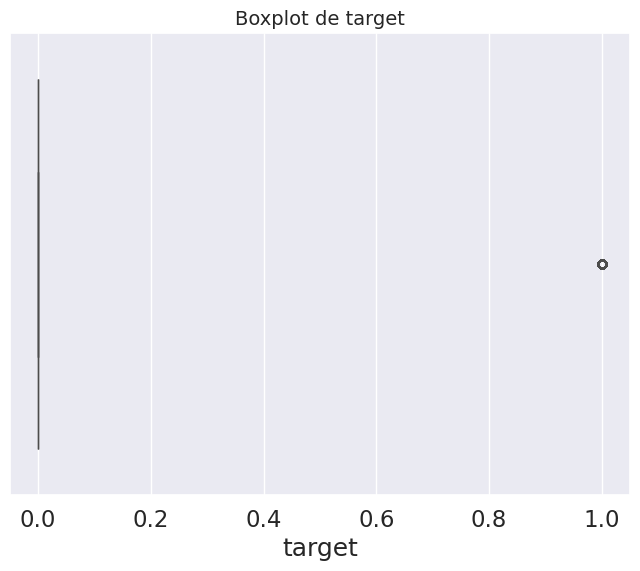

In [84]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['target'])
plt.title('Boxplot de target', fontsize=14)
plt.show()

La variable target, al ser binaria solo se aprecian datos en 0 y 1, en otro caso, si existieran atípicos, se vería algún otro valor por fuera o por intermedio, lo que no se logra apreciar. Por lo que no tiene atípicos.

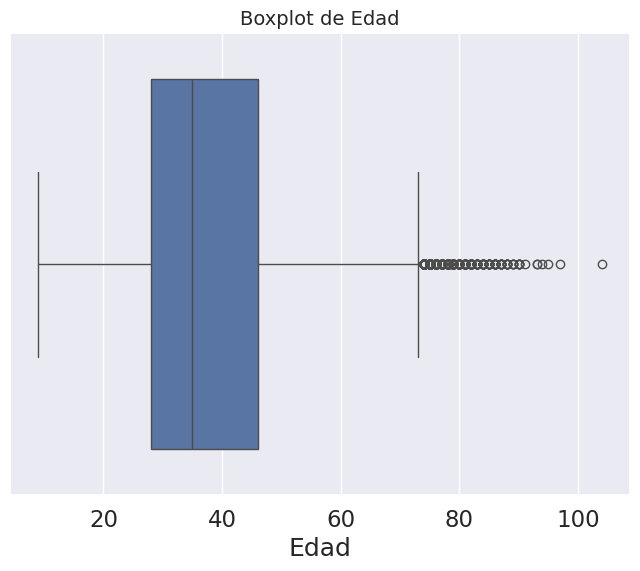

In [85]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['Edad'])
plt.title('Boxplot de Edad', fontsize=14)
plt.show()


La variable edad tiene atípicos hacia la derecha, que es donde más se concentran los puntos, donde el mayor es de 104 años. También, aunque en el gráfico no se aprecia, en el reporte nos indica que la persona con menor edad es de 9 años, lo que se tendría que ver bien, ya que podrían ser errores, o bien, que tengan cuenta vinculada a sus tutores.

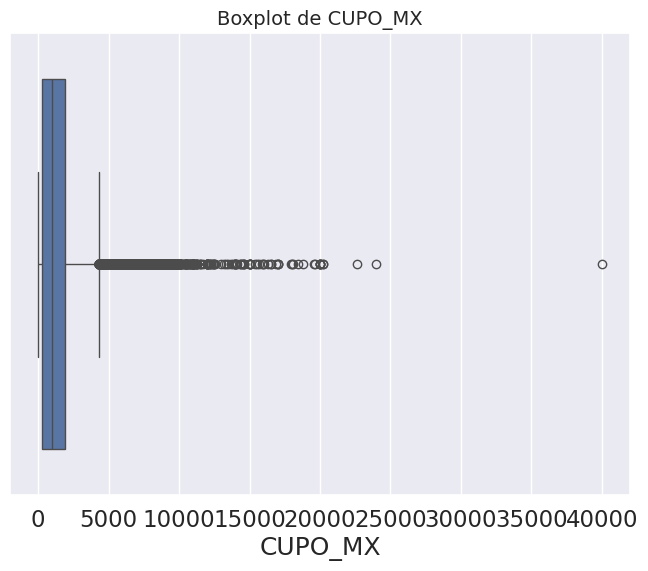

In [86]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['CUPO_MX'])
plt.title('Boxplot de CUPO_MX', fontsize=14)
plt.show()

En este gráfico de caja se aprecian atípicos hacia la derecha, donde el máximo es de 40.000.

A continuación se realiza un algoritmo para las demás variables, en donde se puede apreciar el total de valores atípicos y missing values.

In [87]:
variables_uso = ['FacCN_T12', 'Txs_T12', 'ColL1T0_T12', 'FacCCPC_T12', 'TxsCN_T12', 'Fac_T12', 'FlgActCN_T02',
'FlgActCN_T03',
'FlgActCN_T01',
'FlgActCN_T04',
'ColL1TE_T04',]

missing_data = {}
outliers = {}

for col in variables_uso:
    missing = df[col].isnull().sum()
    missing_data[col] = missing

    # Detectar atípicos usando Z-Score (si el valor de z > 3 es atípico)
    z_scores = zscore(df[col].dropna())  # Eliminar NaN para cálculo de Z-Score
    atipicos = np.sum(np.abs(z_scores) > 3)  # Contar los valores con z-score mayor a 3
    outliers[col] = atipicos

print("Resumen de datos faltantes y atípicos para las columnas seleccionadas:\n")
for col in variables_uso:
    print(f"{col}:")
    print(f"  - Missing values: {missing_data[col]} valores faltantes")
    print(f"  - Atípicos: {outliers[col]} valores atípicos")
    print("-" * 50)


Resumen de datos faltantes y atípicos para las columnas seleccionadas:

FacCN_T12:
  - Missing values: 8251 valores faltantes
  - Atípicos: 751 valores atípicos
--------------------------------------------------
Txs_T12:
  - Missing values: 8251 valores faltantes
  - Atípicos: 949 valores atípicos
--------------------------------------------------
ColL1T0_T12:
  - Missing values: 8251 valores faltantes
  - Atípicos: 806 valores atípicos
--------------------------------------------------
FacCCPC_T12:
  - Missing values: 8251 valores faltantes
  - Atípicos: 633 valores atípicos
--------------------------------------------------
TxsCN_T12:
  - Missing values: 8251 valores faltantes
  - Atípicos: 1019 valores atípicos
--------------------------------------------------
Fac_T12:
  - Missing values: 8251 valores faltantes
  - Atípicos: 749 valores atípicos
--------------------------------------------------
FlgActCN_T02:
  - Missing values: 12 valores faltantes
  - Atípicos: 0 valores atípicos

# Fase 3 - Preparación de los datos

## Tratamiento de nulos y atípicos

A continuación, se usa la técnica capping para manejar los atípicos, con el fin de limitar el impacto de los valores extremos. No se imputa por la mediana, aunque haya atípicos, debido a que, luego no podriamos usar KNNImputer para el manejo de los missing values.

In [88]:
for col in variables_uso:
    lower_percentile = df[col].quantile(0.05)
    upper_percentile = df[col].quantile(0.95)

    # Aplicar el capping
    df[col] = np.where(df[col] < lower_percentile, lower_percentile, df[col])
    df[col] = np.where(df[col] > upper_percentile, upper_percentile, df[col])

El tratamiento de nulos se realizará usando KNNImputer, debido a que se adapta a patrones reales que se hallan en los datos, por lo que son muy representativos. Esto mejora la calidad de los datos imputados, sobre todo cuando se planea escalar, que es nuestro caso.

In [89]:
# Escriba su código acá
num_cols = ['FacCN_T12',
'Txs_T12',
'ColL1T0_T12',
'FacCCPC_T12',
'TxsCN_T12',
'Fac_T12']

imputer = KNNImputer(n_neighbors=5)
df[num_cols] = imputer.fit_transform(df[num_cols])

In [90]:
col_clf = ['FlgActCN_T02',
'FlgActCN_T03',
'FlgActCN_T01',
'FlgActCN_T04',
'ColL1TE_T04',
'target']

df[col_clf] = imputer.fit_transform(df[col_clf])

## Transformación de variables

La idea de escalar, es que las variables se ajusten a las demás, donde por ejemplo, los datos de edad, son mucho más bajos que los de Fac_T12, por lo que es necesario escalar a una medida, donde estos valores no sean tan desiguales. Esto puede hacer que las variables con escalas muy grandes, dominen los modelos. Y eso es lo que se hace a continuación.

In [91]:
# Escriba su código acá
df_numerico = df.select_dtypes(include=['number'])

target = df_numerico['target']
features = df_numerico.drop(columns=['target'])

scaler = StandardScaler()
array_scaler = scaler.fit_transform(features)

df_scaler = pd.DataFrame(array_scaler, columns=features.columns)

df_scaler['target'] = target.reset_index(drop=True)

# Fase 4 - Modelamiento

## Modelos de regresión

### Definición de Variable objetivo

Se analizará a la variable "Fac_T12", que nos dice el monto de la factura por el cliente en la tarjeta de crédito en el mes 12. Con el fin de segmentar a los clientes como: rango alto, rango medio, rango bajo o inactivo. Esto, con la finalidad de definir estrategías de marketing personalizadas. Además de ayudar a gestionar riesgos en cuanto a créditos que se les puedan otorgar. Además, al ser una variable continua, es perfecta candidata para modelos de regresión.

In [92]:
# Escriba su código acá
y = df['Fac_T12']
data_y = pd.DataFrame(y)

### Distribución de variable objetivo

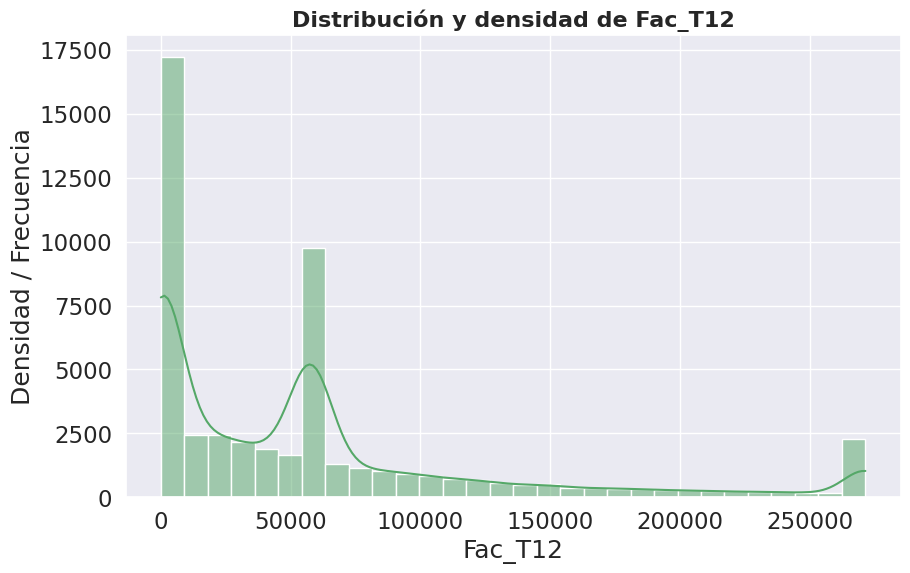

In [93]:
# Escriba su código acá
plt.figure(figsize=(10, 6))
sns.histplot(df['Fac_T12'], bins=30, kde=True, color=sns.color_palette()[2])
plt.title("Distribución y densidad de Fac_T12", fontsize=16, fontweight="bold")
plt.xlabel("Fac_T12")
plt.ylabel("Densidad / Frecuencia")
plt.show()

En el gráfico se aprecia que la mayoría de personas están en el rango de 0 a 1.000.000 de pesos, donde se aprecia también que hay quienes están debajo del 0, lo que se podría deber a un error de tipeo, o algún otro factor.

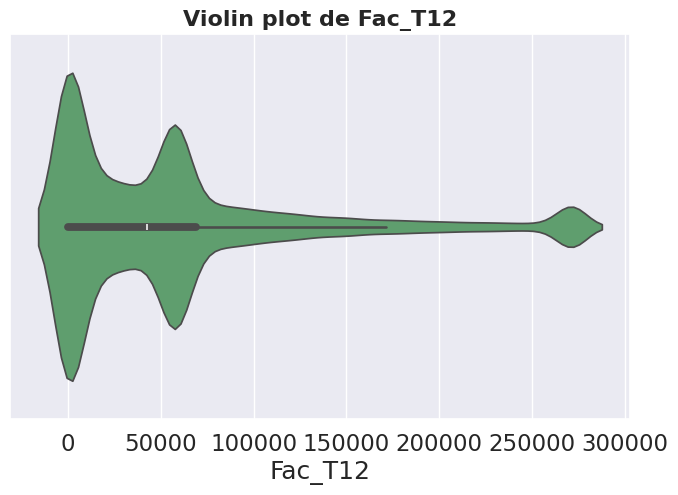

In [94]:
plt.figure(figsize=(8, 5))
sns.violinplot(x=df['Fac_T12'], color=sns.color_palette()[2])
plt.title("Violin plot de Fac_T12", fontsize=16, fontweight="bold")
plt.xlabel("Fac_T12")
plt.show()

Con este gráfico reforzamos la idea anterior.

### Selección de variables independientes

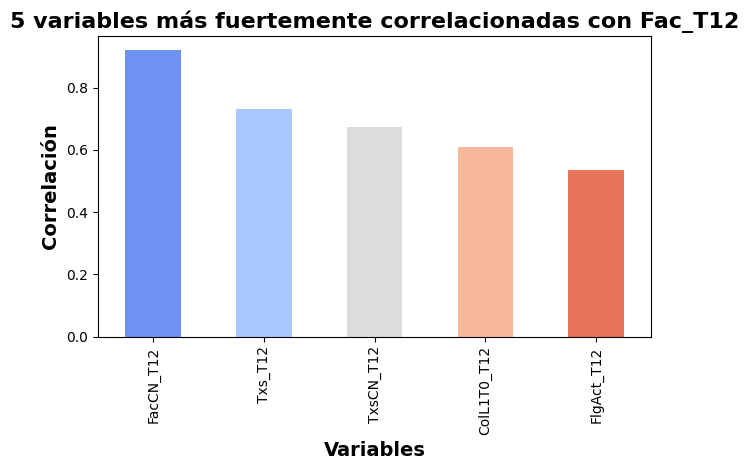

In [26]:
data_copia = df_scaler.copy()
data_copia['Fac_T12'] = y
corrs = data_copia.corr(numeric_only=True)['Fac_T12'].drop('Fac_T12').sort_values(ascending=False)

top_abs_corrs = corrs.abs().sort_values(ascending=False).head(5)

top_corrs_signed = corrs.loc[top_abs_corrs.index]

ax = top_corrs_signed.plot(kind='bar', color=sns.color_palette("coolwarm", 5))
ax.set_title('5 variables más fuertemente correlacionadas con Fac_T12', fontsize=16, fontweight='bold')
ax.set_ylabel('Correlación', fontsize=14, fontweight="bold")
ax.set_xlabel('Variables', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

Este gráfico nos ayuda a seleccionar las variables candidatas a predecir nuestra variable objetivo, de las cuales se escogen las más "fuertes", y nos muestra que son: FacCN_T12',
'Txs_T12',
'ColL1T0_T12',
'FacCCPC_T12',
'TxsCN_T12'. Por lo cual se prodecerá a trabajar con ellas.

In [95]:
#Se seleccionan las variables de "num_cols", "quitando Fac_T12", debido a que es nuestra variable objetivo
X = df_scaler[[col for col in num_cols if col != 'Fac_T12']]
data_x = pd.DataFrame(X)

### Separación datos de entrenamiento y test

In [96]:
# Escriba su código acá
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=29)

### Algoritmo 1 - `Regresion Polinomial`

#### Creación del modelo

Para el algoritmo de Regresión Polinomial, se usa un grado polinomial de 3, debido a que no requiere de un analisis muy complejo, y no queremos generar un sobreajuste.
También se usa el 30% de datos para pruebas, para los demás usarlos de test.

In [97]:
# Escriba su código acá
grado_polinomio = 3
polyfeats = PolynomialFeatures(degree=grado_polinomio, include_bias=True)

X_train_poly = polyfeats.fit_transform(X_train)
X_test_poly = polyfeats.transform(X_test)

#### Entrenamiento del modelo

In [98]:
# Escriba su código acá
reg_poly = LinearRegression(fit_intercept=False)
reg_poly.fit(X_train_poly, y_train)
y_pred = reg_poly.predict(X_test_poly)

#### Evaluación del modelo

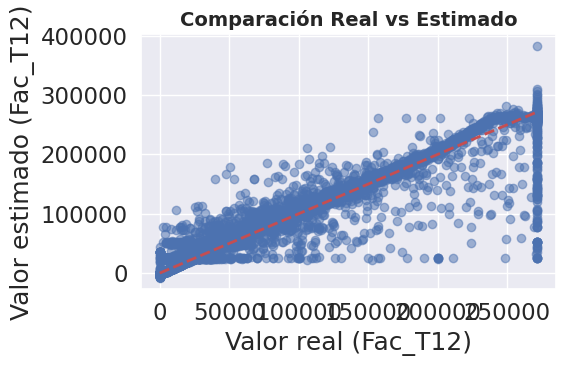

In [99]:
# Escriba su código acá
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)  # línea ideal
plt.xlabel("Valor real (Fac_T12)")
plt.ylabel("Valor estimado (Fac_T12)")
plt.title("Comparación Real vs Estimado", fontsize=14, fontweight="bold")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Cálculo e interpretación de métricas

##### R2

In [32]:
print("Entrenamiento R^2:", reg_poly.score(X_train_poly, y_train))
print("Prueba R^2:", reg_poly.score(X_test_poly, y_test))

Entrenamiento R^2: 0.9402852407143886
Prueba R^2: 0.9364961839896114


Aquí se aprecia que los datos de entrenamiento predicen un 94% de Fac_T12, mientras que los datos de prueba un 93%, lo que dice que nuestro modelo está generalizando bien y no se aprecia ni overfitting ni underfitting. Tan solo con una diferencia del 1%.

##### MAE

In [33]:
# Escriba su código acá
mae = mean_absolute_error(y_test, y_pred)
print('Mean absolute error (MAE): %.2f' % mae)

Mean absolute error (MAE): 5440.08


Un mean absolute error de 5440.08, quiere decir que el error promedio es de 5440 pesos.

### Algoritmo 2 - `DecisionTreeRegressor`

#### Creación del modelo

Se crea un árbol de profundidad 5, debido a que es más fácil de interpretar.

In [34]:
# Escriba su código acá
reg_tree = DecisionTreeRegressor(max_depth=5)

#### Entrenamiento del modelo

Profundidad del árbol: 5


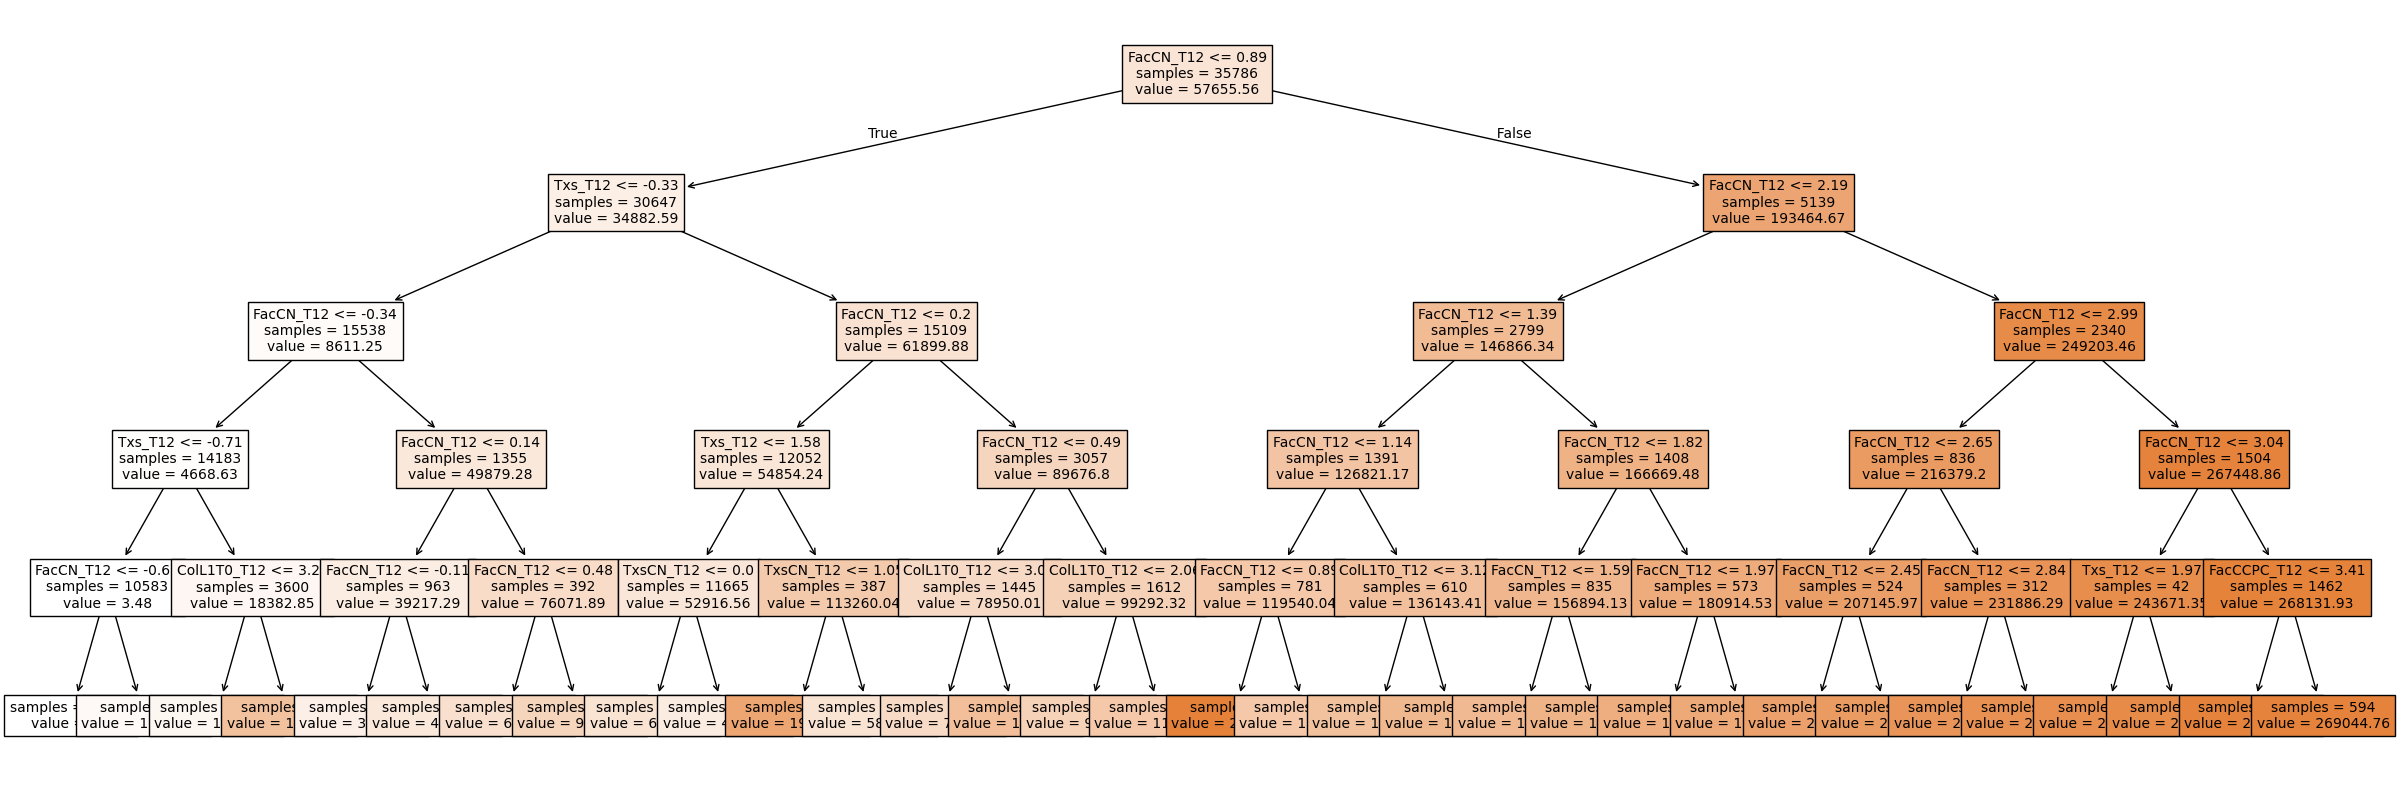

In [35]:
# Escriba su código acá
reg_tree.fit(X_train, y_train)
y_predicted = reg_tree.predict(X_test)

# Visualización
fig, ax = plt.subplots(figsize=(30, 10))
print('Profundidad del árbol:', reg_tree.get_depth())

plot = plot_tree(decision_tree = reg_tree,
      feature_names = data_x.columns,
      filled = True,
      impurity = False,
      fontsize = 10,
      precision = 2,
      ax = ax)

El árbol nos muestra qué variables son más importantes para la predición, en este caso, como se puede apreciar, las variables FacCN_T12 y FacCCPC_T12, son con diferencia, las más relevantes.

#### Evaluación del modelo

#### Cálculo e interpretación de métricas

##### R2

In [36]:
# Escriba su código acá
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_predicted))

Coefficient of determination: 0.90


Un 90% de R2, nos indica una fuerte relación entre las variables independientes y la dependiente.

In [37]:
y_predicted_train = reg_tree.predict(X_train)
print('Coefficient of determination: %.2f'
      % r2_score(y_train, y_predicted_train))

Coefficient of determination: 0.91


Aquí apreciamos como le fue con el set de entrenamiento. En este caso se aprecia una diferencia del 1%, lo que nos indica que generaliza bien y no se aprecia ni overfitting ni underfitting.

##### MAE

In [38]:
# Escriba su código acá
print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test, y_predicted))

Mean absolute error: 8794.56


Aquí el MAE nos muestra que se equivoca en promedio 8.794 pesos.

### Comparación de los modelos

En ambos modelos se aprecia un r^2 elevado. Regresion Polinomial con un 94%, mientras que DecisionTreeRegressor, con un 91%. Además, el MAE nos indica que se equivocan en un 5440 y 8794 respectivamente.


Y aunque las diferencias no son exageradas, el modelo de Regresion Polinomial, tiene un r^2 más elevado y sin sintomas de overfitting ni underfitting, además, cuenta con una MAE menor.

**Por estas razones se escoge a Regresion Polinomial como el mejor modelo de regresión.**

## Modelo de clasificación

### Distribución de variable objetivo

La variable objetivo es 'target'. Con esta sabremos si los cliente pagan o no pagan la totalidad de la tarjeta de crédito. Lo cual es muy importante para un banco ya que se pueden gestionar los riesgos gracias a esta información. Además de ser una variable binaria, donde 0 significa que no paga en su totalidad, y 1, que paga en su totalidad. Esto quiere decir que es perfecta candidata para un modelo de clasificación.

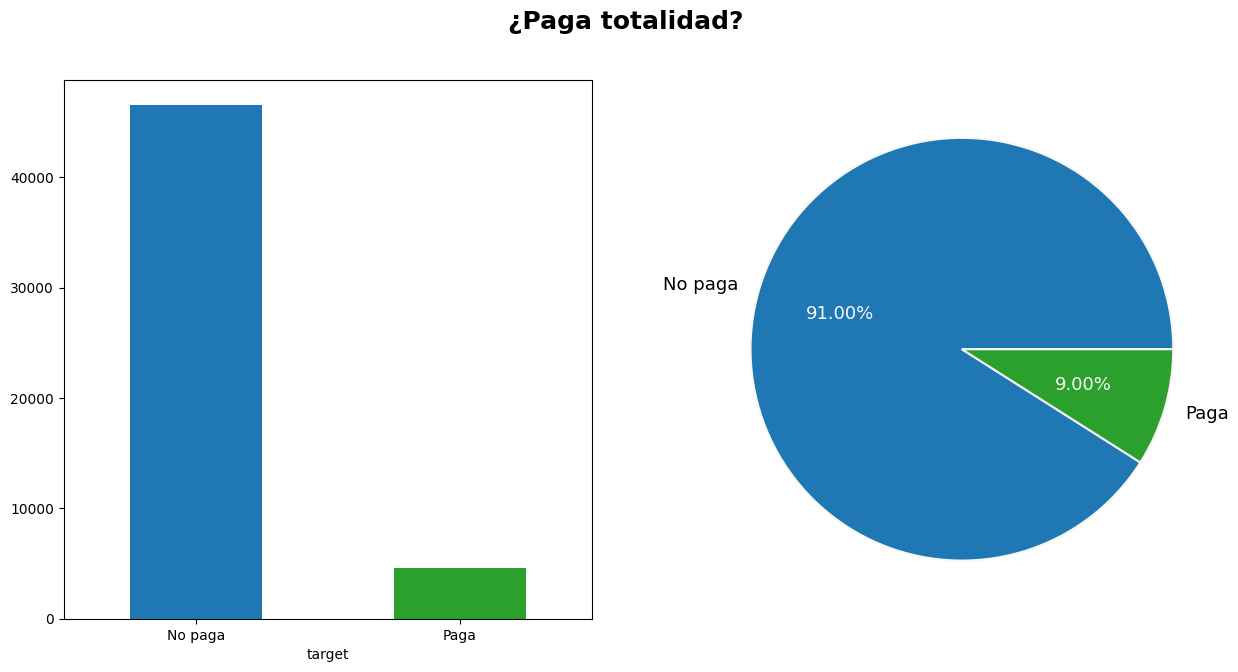

In [39]:
# Escriba su código acá
y_clf = df_scaler["target"]

f, ax = plt.subplots(1, 2, figsize = (15, 7))
f.suptitle("¿Paga totalidad?", fontsize = 18., fontweight="bold")
_ = df_scaler.target.value_counts().plot.bar(ax = ax[0], rot = 0, color = (sns.color_palette()[0], sns.color_palette()[2])).set(xticklabels = ["No paga", "Paga"])
_ = df_scaler.target.value_counts().plot.pie(labels = ("No paga", "Paga"), autopct = "%.2f%%", label = "", fontsize = 13., ax = ax[1],\
colors = (sns.color_palette()[0], sns.color_palette()[2]), wedgeprops = {"linewidth": 1.5, "edgecolor": "#F7F7F7"}), ax[1].texts[1].set_color("#F7F7F7"), ax[1].texts[3].set_color("#F7F7F7")

Aquí se aprecia que los que pagan completamente la tarjeta, son muy inferiores a los que no pagan. Debido a esto, la máquina tenderá a predecir que los clientes no pagan en su totalidad su tarjeta, lo que producirá un sesgo.

### Selección de variables independientes

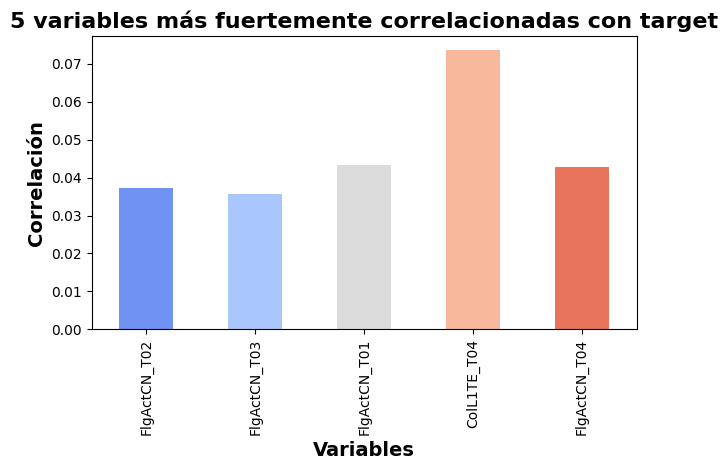

In [40]:
# Escriba su código acá
corrs_clf = data_copia.corr(numeric_only=True)['target'].drop('target').sort_values(ascending=False)

top_abs_corrs_clf = corrs_clf.abs().sort_values(ascending=False).head(5)

top_corrs_signed_clf = corrs.loc[top_abs_corrs_clf.index]

ax = top_corrs_signed_clf.plot(kind='bar', color=sns.color_palette("coolwarm", 5))
ax.set_title('5 variables más fuertemente correlacionadas con target', fontsize=16, fontweight='bold')
ax.set_ylabel('Correlación', fontsize=14, fontweight="bold")
ax.set_xlabel('Variables', fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

En este gráfico analizamos las variables con mejor correlación con "target", nuestra variable objetivo. Se aprecia que son: 'FlgActCN_T02',
'FlgActCN_T03',
'FlgActCN_T01',
'FlgActCN_T04'y
'ColL1TE_T04'.

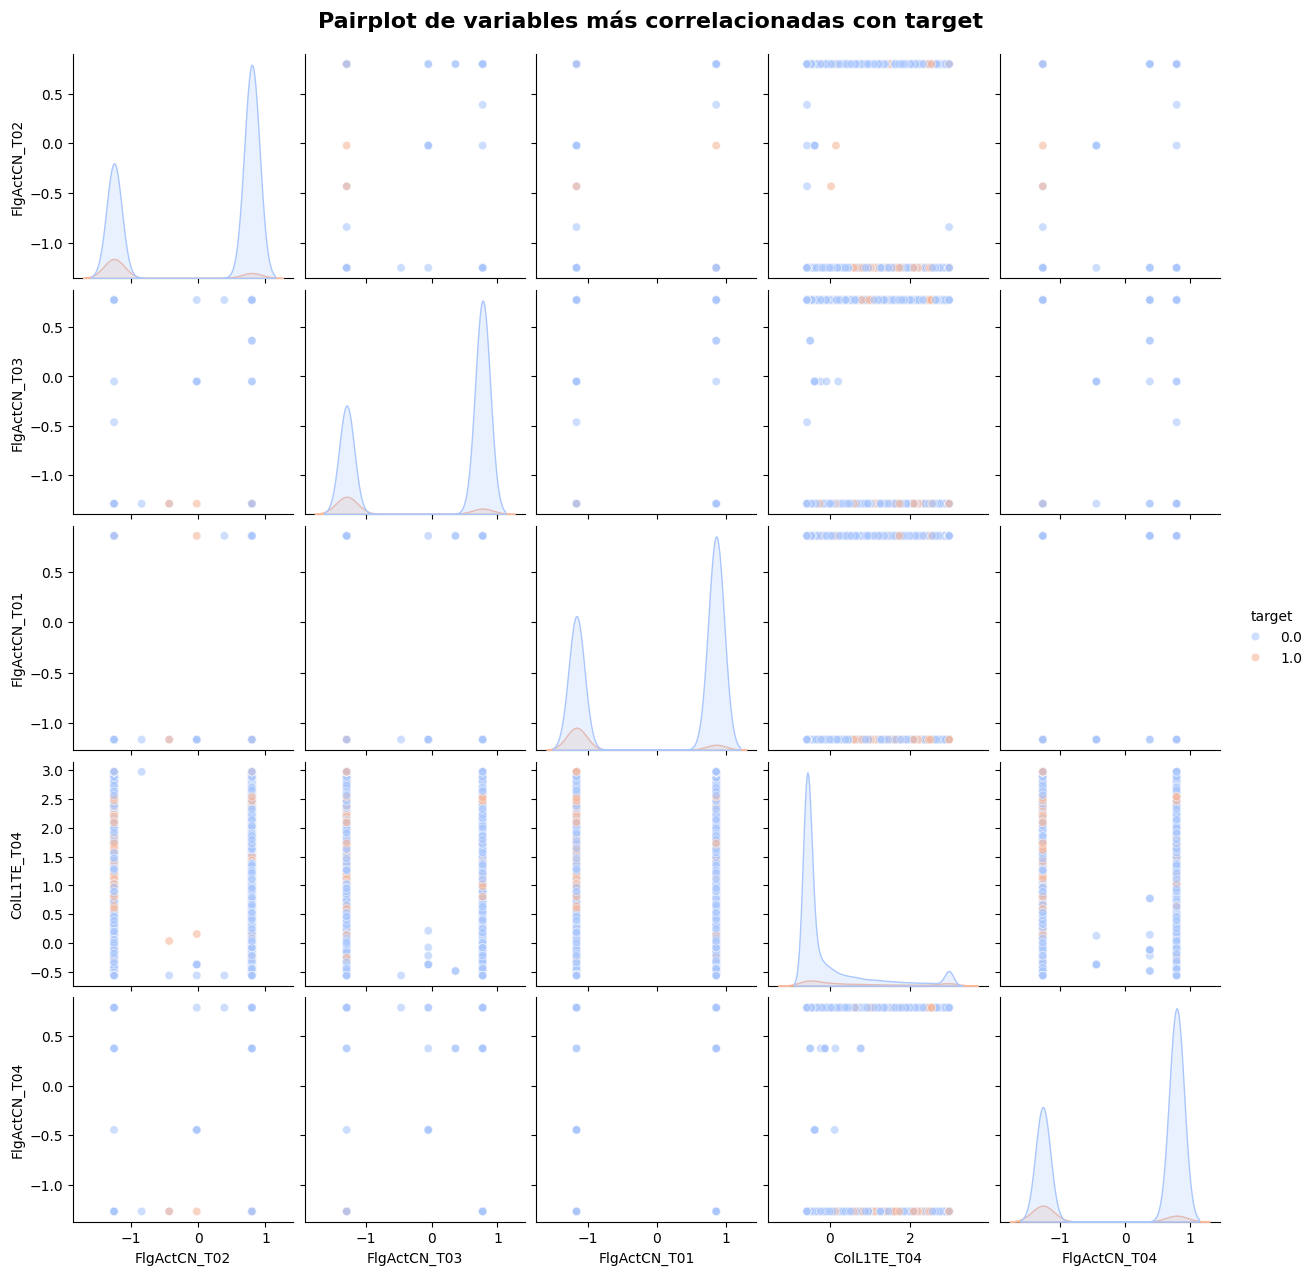

In [41]:
# Escriba su código acá
top_vars = top_corrs_signed_clf.index.tolist()
top_vars.append('target')

sns.pairplot(data=data_copia[top_vars], hue='target', palette="coolwarm", plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot de variables más correlacionadas con target", fontsize=16, fontweight="bold", y=1.02)
plt.show()

Estos gráficos nos muestran las variables que se correlacionan con target y así detectar si tienen un buen poder predictivo.

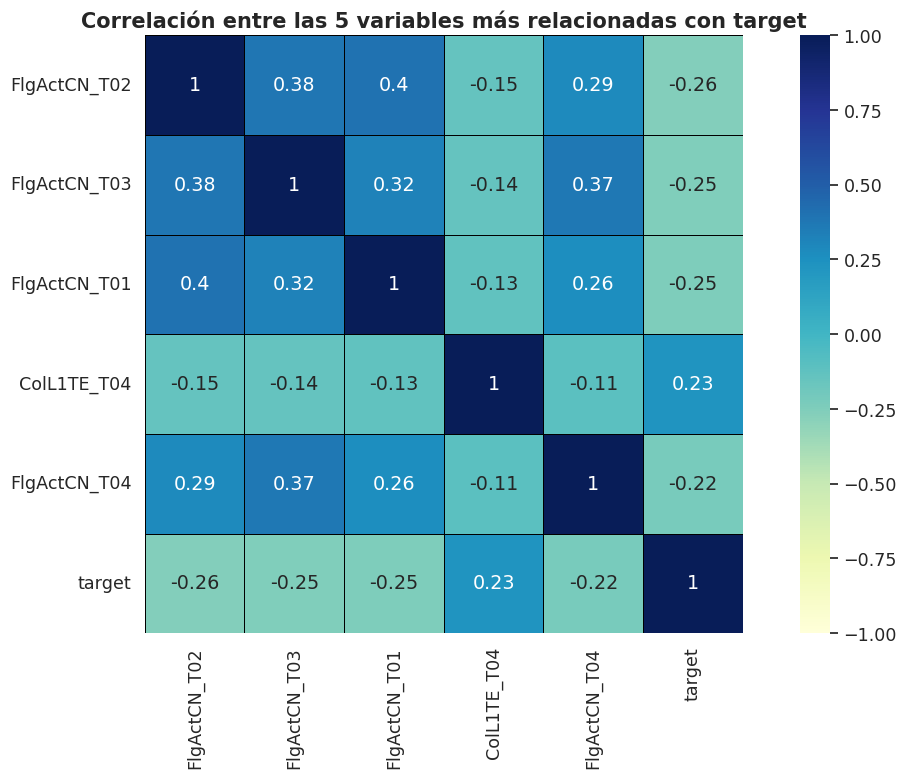

In [42]:
corr_matrix = data_copia[top_vars].corr()

sns.set(font_scale=1.15)
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu',
            linewidths=0.5, linecolor='black', square=True, vmin=-1, vmax=1, center=0)

plt.title('Correlación entre las 5 variables más relacionadas con target', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

Aquí vemos un mapa de calor, donde nos indica correlaciones tanto positivas como negativas, por ejemplo: ColL1TE_T04 tiene una correlación positiva de 0.2 con target, mientras que FlgActCN_T03 tiene una correlación negativa de -0.25.

In [43]:
X_clf = df_scaler[[col for col in col_clf if col != 'target']]
data_x_clf = pd.DataFrame(X_clf)

### Separación datos entrenamiento y test

In [44]:
# Escriba su código acá
A_train, A_test, b_train, b_test = train_test_split(data_x_clf, y_clf, test_size=0.2, random_state = 29, stratify=y_clf)

### Algoritmo 1 - DecisionTreeClassifier

#### Creación del modelo

Se usará tanto Gini como Entropy, para realizar una eventual comparación. Importante aclarar que se usa class_weight con el objetivo de realizar un balance de clases y que no haya un sesgo a la hora de entrenar al modelo.

In [58]:
# Escriba su código acá
clf_gini = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    min_samples_leaf=10,
    class_weight='balanced',  # balance de clases
    random_state=29
)

clf_entropy = DecisionTreeClassifier(
    criterion = "entropy",
    max_depth = 3,
    min_samples_leaf = 20,
    class_weight='balanced',  # balance de clases
    random_state = 29)

#### Entrenamiento del modelo

In [60]:
# Escriba su código acá
clf_gini.fit(A_train, b_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=10, random_state=29)

In [61]:
clf_entropy.fit(A_train, b_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, min_samples_leaf=20, random_state=29)

#### Evaluación del modelo

#### Cálculo e interpretación de métricas

##### Matriz de confusión

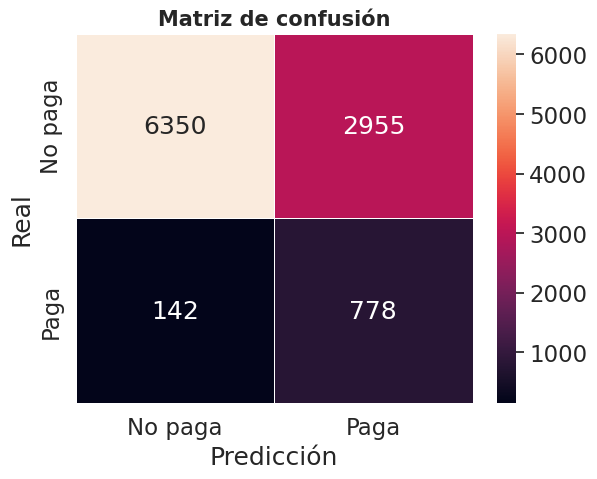



Accuracy  70.81662591687041


In [62]:
# Escriba su código acá
# Gráfica de la matriz de confusión
b_pred_entropy = clf_entropy.predict(A_test)

clases = ["No paga","Paga"]
sns.set(font_scale=1.5)
cm = confusion_matrix(b_test, b_pred_entropy)
sns.heatmap(cm, annot=True, fmt='g', linewidth=.7, xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión", fontsize=15, fontweight="bold")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.show()
# Accuracy
print("\n\nAccuracy ", clf_gini.score(A_test, b_test)*100)

El gráfico de confusión con entropy predijo 6350 verdaderos positivos, 142 falsos negativos, 2955 falsos positivos, y finalmente, 778 verdaderos negativos.

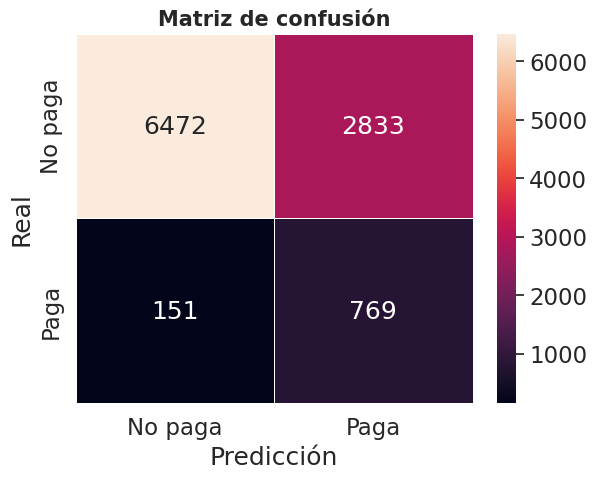



Accuracy  70.81662591687041


In [100]:
y_pred_gini = clf_gini.predict(A_test)

clases = ["No paga","Paga"]
sns.set(font_scale=1.5)
cm = confusion_matrix(b_test, y_pred_gini)
sns.heatmap(cm, annot=True, fmt='g', linewidth=.7, xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión", fontsize=15, fontweight="bold")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.show()
# Accuracy
print("\n\nAccuracy ", clf_gini.score(A_test, b_test)*100)

Mientras que con Gini predijo 6472 verdaderos positivos, 151 falsos negativos, 2833 falsos positivos, y finalmente, 769 verdaderos negativos.

##### Accuracy

In [50]:
# Escriba su código acá
print ("Accuracy : {}".format(accuracy_score(b_test,y_pred_gini)*100))
print ("Reporte\n",  classification_report(b_test, y_pred_gini, target_names=['No paga completamenete', 'Paga completamenete']))

Accuracy : 70.81662591687041
Reporte
                         precision    recall  f1-score   support

No paga completamenete       0.98      0.70      0.81      9305
   Paga completamenete       0.21      0.84      0.34       920

              accuracy                           0.71     10225
             macro avg       0.60      0.77      0.58     10225
          weighted avg       0.91      0.71      0.77     10225



Aquí apreciamos claramente el sesgo, dado que, mientras la predicción en no paga completamente (que es el mayor conjunto de datos), tiene una precisión del 98%, y con la otra alternativa, tenemos solo un 21%.

**En cuanto al "no paga completamente", tenemos que: **

  Precision = 0.98: De todas las veces que el modelo predijo "no paga", el 98% fueron correctas.

  Recall = 0.70: De todas las personas que realmente "no pagaban", el modelo detectó el 70%.

  F1-score = 0.81: Buen equilibrio entre precision y recall.

**Mientras que en "paga completamenete": **

  Precision = 0.21: Solo el 21% de los que el modelo predijo como "paga", realmente pagaban.

  Recall = 0.84: De todas las personas que realmente "pagan", el modelo detecta el 84%.

  F1-score = 0.34: Bajo, indica un mal equilibrio.


In [51]:
print ("Accuracy : {}".format(accuracy_score(b_test,b_pred_entropy)*100))
print ("Reporte\n",  classification_report(b_test, b_pred_entropy,
                                           target_names=['No paga', 'Paga']))

Accuracy : 69.71149144254278
Reporte
               precision    recall  f1-score   support

     No paga       0.98      0.68      0.80      9305
        Paga       0.21      0.85      0.33       920

    accuracy                           0.70     10225
   macro avg       0.59      0.76      0.57     10225
weighted avg       0.91      0.70      0.76     10225



**En cuanto al "no paga completamente", tenemos que: **

  Precision = 0.98: De todas las veces que el modelo predijo "no paga", el 98% fueron correctas.

  Recall = 0.68: De todas las personas que realmente "no pagaban", el modelo detectó el 68%.

  F1-score = 0.80: Buen equilibrio entre precision y recall.

**Mientras que en "paga completamenete": **

  Precision = 0.21: Solo el 21% de los que el modelo predijo como "paga", realmente pagaban.

  Recall = 0.85: De todas las personas que realmente "pagan", el modelo detecta el 85%.

  F1-score = 0.33: Bajo, indica un mal equilibrio.

Con entropia tenemos prácticamente, los mismos resultados.

In [52]:
y_pred_gini_train = clf_gini.predict(A_train)
b_pred_entropy_train = clf_entropy.predict(A_train)

print ("Accuracy : {}".format(accuracy_score(b_train,y_pred_gini_train)*100))
print ("Reporte\n",  classification_report(b_train, y_pred_gini_train, target_names=['No paga completamenete', 'Paga completamenete']))

print("-------------------------------------------------")

print ("Accuracy : {}".format(accuracy_score(b_train,b_pred_entropy_train)*100))
print ("Reporte\n",  classification_report(b_train, b_pred_entropy_train, target_names=['No paga completamenete', 'Paga completamenete']))

Accuracy : 71.55431673146043
Reporte
                         precision    recall  f1-score   support

No paga completamenete       0.98      0.70      0.82     37219
   Paga completamenete       0.22      0.83      0.34      3680

              accuracy                           0.72     40899
             macro avg       0.60      0.77      0.58     40899
          weighted avg       0.91      0.72      0.78     40899

-------------------------------------------------
Accuracy : 70.57874275654662
Reporte
                         precision    recall  f1-score   support

No paga completamenete       0.98      0.69      0.81     37219
   Paga completamenete       0.21      0.84      0.34      3680

              accuracy                           0.71     40899
             macro avg       0.59      0.77      0.57     40899
          weighted avg       0.91      0.71      0.77     40899



Si comprobamos con los datos de entrenamiento, tenemos practicamente los mismos resultados. Lo que quiere decir que el modelo está generalizando correctamente.

#### Aplicación de `CrossValidation`

In [53]:
# Escriba su código acá
scores = cross_val_score(clf_entropy, A_train, b_train, cv=5)
print(scores)
print("{0:<25} : {1:.2f}".format("El promedio es", np.mean(scores)))
print("{0:<25} : {1:.2f}".format("La desviacion estandar es", np.std(scores) ))

[0.71198044 0.69718826 0.71882641 0.70085575 0.70204181]
El promedio es            : 0.71
La desviacion estandar es : 0.01


Aplicando CrossValidation, nos damos cuenta que nos confirma nuestro accuracy del 71% (en entropia), y que, además, tenemos una desviación estandar del 1%, por lo que podemos decir que el modelo es estable.

In [54]:
cv_results = cross_validate(clf_entropy, A_train, b_train, cv=5)
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_score'])

#### Análisis de métricas usando `CrossValidation`

In [55]:
print(cv_results['fit_time'])
print("---------------")
print(cv_results['score_time'])
print("---------------")
print(cv_results['test_score'])

[0.02939034 0.02920341 0.02934742 0.0293591  0.02884722]
---------------
[0.00296879 0.00294709 0.00289464 0.00291681 0.00288701]
---------------
[0.71198044 0.69718826 0.71882641 0.70085575 0.70204181]


### Algoritmo 2 - SVM

#### Creación del modelo

A continuación se avergigua cuál kernel nos conviene, esto con el objetivo de aplicar el mejor para nuestro caso. Además de usar la clase de class_weight='balanced', para aplicar el balance de clases, y que así, el modelo no se deje llevar por un sesgo.

In [101]:
# Escriba su código acá
#Este código es para ver cual kernel nos conviene
for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
  svc = SVC(kernel=kernel)
  scores = cross_val_score(svc, data_x_clf, y_clf, cv=5)
  print(f"Kernel: {kernel}, Accuracy: {scores.mean():.4f}")

# SVM con Kernel gaussiano
model = SVC(kernel='rbf', class_weight='balanced')

Kernel: linear, Accuracy: 0.9100
Kernel: rbf, Accuracy: 0.9111
Kernel: poly, Accuracy: 0.9100
Kernel: sigmoid, Accuracy: 0.8535


#### Entrenamiento del modelo

In [103]:
# Escriba su código acá
model.fit(A_train, b_train)
b_predicted = model.predict(A_test)

#### Evaluación del modelo

#### Cálculo e interpretación de métricas

##### Matriz de confusión

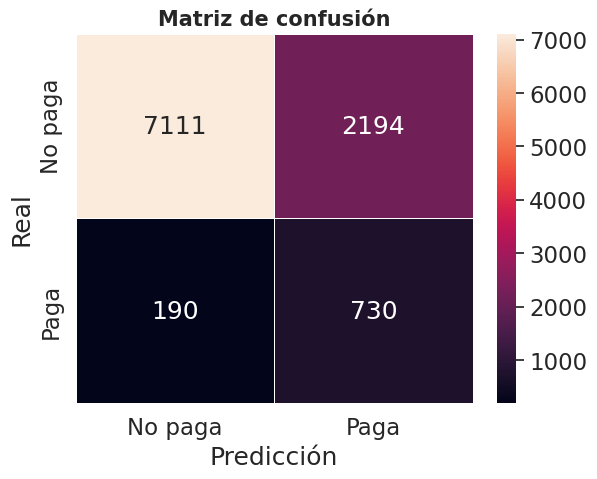

In [75]:
# Escriba su código acá
clases = ["No paga","Paga"]
sns.set(font_scale=1.5)
cm = confusion_matrix(b_test, b_predicted)
sns.heatmap(cm, annot=True, fmt='g', linewidth=.7, xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión", fontsize=15, fontweight="bold")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.show()

El modelo SVM predijo 9153 verdaderos positivos, 764 falsos negativos, 152 falsos positivos, y finalmente, 156 verdaderos negativos.

##### Accuracy

In [77]:
# Escriba su código acá
print(classification_report(b_test, b_predicted))

              precision    recall  f1-score   support

         0.0       0.97      0.76      0.86      9305
         1.0       0.25      0.79      0.38       920

    accuracy                           0.77     10225
   macro avg       0.61      0.78      0.62     10225
weighted avg       0.91      0.77      0.81     10225



Tenemos un accuracy  del 91%. Donde tenemos que los que pagan completamente tienen un 51% de aciertos por parte de la máquina.

**En cuanto al "no paga completamente", tenemos que: **

  Precision = 0.97: De todas las veces que el modelo predijo "no paga", el 97% fueron correctas.

  Recall = 0.76: De todas las personas que realmente "no pagaban", el modelo detectó el 76%.

  F1-score = 0.86: Buen equilibrio entre precision y recall.

**Mientras que en "paga completamenete": **

  Precision = 0.25: Solo el 25% de los que el modelo predijo como "paga", realmente pagaban.

  Recall = 0.79: De todas las personas que realmente "pagan", el modelo detecta el 79%.

  F1-score = 0.38: Bajo, indica un mal equilibrio.

In [104]:
b_predicted_train = model.predict(A_train)
print(classification_report(b_train, b_predicted_train))

              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86     37219
         1.0       0.26      0.79      0.39      3680

    accuracy                           0.78     40899
   macro avg       0.62      0.78      0.63     40899
weighted avg       0.91      0.78      0.82     40899



Comparandolo con los datos de entrenamiento son casi identicos, por lo que podemos decir que está haciendo un buen trabajo de generalización.

**En cuanto al "no paga completamente", tenemos que: **

  Precision = 0.97: De todas las veces que el modelo predijo "no paga", el 97% fueron correctas.

  Recall = 0.77: De todas las personas que realmente "no pagaban", el modelo detectó el 77%.

  F1-score = 0.86: Buen equilibrio entre precision y recall.

**Mientras que en "paga completamenete": **

  Precision = 0.26: Solo el 26% de los que el modelo predijo como "paga", realmente pagaban.

  Recall = 0.79: De todas las personas que realmente "pagan", el modelo detecta el 79%.

  F1-score = 0.39: Bajo, indica un mal equilibrio.

#### Aplicación de `CrossValidation`

In [105]:
# Escriba su código acá
scores = cross_val_score(model, A_train, b_train, cv=5)
print(scores)

print("{0:<25} : {1:.2f}".format("El promedio es", np.mean(scores)))
print("{0:<25} : {1:.2f}".format("La desviacion estandar es", np.std(scores) ))

[0.75488998 0.7690709  0.76210269 0.76833741 0.77747891]
El promedio es            : 0.77
La desviacion estandar es : 0.01


Aquí corroboramos un accuracy similar, además nos enseña una desviación estandar de 0, lo que nos indica que no hay variaciones en el modelo.

In [106]:
cv_results = cross_validate(model, A_train, b_train, cv=5)
cv_results.keys()

cv_results['fit_time']

array([38.55317116, 33.89898181, 35.62193298, 35.91304517, 34.35494709])

#### Análisis de métricas usando `CrossValidation`

In [107]:
# Escriba su código acá
print(cv_results['fit_time'])
print("---------------")
print(cv_results['score_time'])
print("---------------")
print(cv_results['test_score'])

[38.55317116 33.89898181 35.62193298 35.91304517 34.35494709]
---------------
[6.24533963 7.35420299 7.50255799 6.21354008 6.12652516]
---------------
[0.75488998 0.7690709  0.76210269 0.76833741 0.77747891]


### Algoritmo 3 - KNN

#### Creación del modelo

In [108]:
# Escriba su código acá
modelo = KNeighborsClassifier()

#### Entrenamiento del modelo

In [109]:
# Escriba su código acá
modelo.fit(A_train, b_train)

KNeighborsClassifier()

#### Evaluación del modelo

In [110]:
# Escriba su código acá
b_predi = modelo.predict(A_test)

#### Cálculo e interpretación de métricas

##### Matriz de confusión

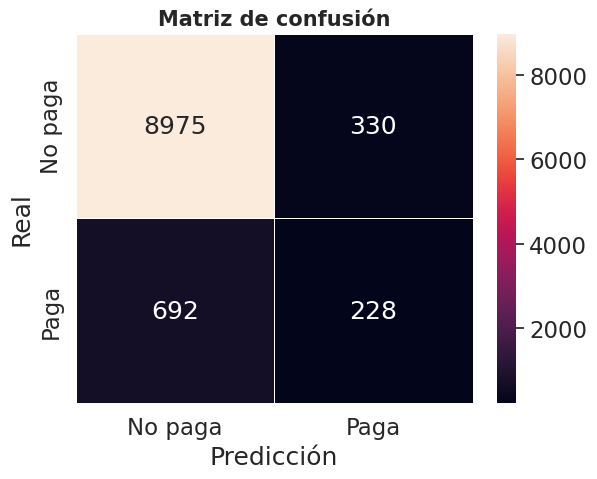



Accuracy  70.81662591687041


In [111]:
# Escriba su código acá
clases = ["No paga","Paga"]
sns.set(font_scale=1.5)
cm = confusion_matrix(b_test, b_predi)
sns.heatmap(cm, annot=True, fmt='g', linewidth=.7, xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión", fontsize=15, fontweight="bold")
plt.xlabel("Predicción"); plt.ylabel("Real")
plt.show()
# Accuracy
print("\n\nAccuracy ", clf_gini.score(A_test, b_test)*100)

El modelo KNN predijo 8975 verdaderos positivos, 692 falsos negativos, 330 falsos positivos, y finalmente, 228 verdaderos negativos.

##### Accuracy

In [112]:
# Escriba su código acá
print(classification_report(b_test, b_predi, target_names = ['No paga', 'Paga']))

              precision    recall  f1-score   support

     No paga       0.93      0.96      0.95      9305
        Paga       0.41      0.25      0.31       920

    accuracy                           0.90     10225
   macro avg       0.67      0.61      0.63     10225
weighted avg       0.88      0.90      0.89     10225



Aquí apreciamos que el modelo tiene un 90% de accuracy. Además, se nota el sesgo en la opción de paga completamente, debido al amplio menor % en comparación a "No paga".

**En cuanto al "no paga completamente", tenemos que: **

  Precision = 0.93: De todas las veces que el modelo predijo "no paga", el 93% fueron correctas.

  Recall = 0.97: De todas las personas que realmente "no pagaban", el modelo detectó el 97%.

  F1-score = 0.95: Buen equilibrio entre precision y recall.

**Mientras que en "paga completamenete": **

  Precision = 0.42: Solo el 42% de los que el modelo predijo como "paga", realmente pagaban.

  Recall = 0.21: De todas las personas que realmente "pagan", el modelo detecta el 21%.

  F1-score = 0.28: Bajo, indica un mal equilibrio.

#### Aplicación de `CrossValidation`

In [114]:
# Escriba su código acá
scores = cross_val_score(modelo, A_train, b_train, cv=5)
print(scores)

print("{0:<25} : {1:.2f}".format("El promedio es", np.mean(scores)))
print("{0:<25} : {1:.2f}".format("La desviacion estandar es", np.std(scores) ))

[0.90525672 0.89694377 0.90036675 0.90452323 0.90279985]
El promedio es            : 0.90
La desviacion estandar es : 0.00


Además de comprobar la accuracy, también apreciamos que tiene una desviación estandar de 0, lo que nos indica que el modelo no tiene varianzas.

In [115]:
cv_results = cross_validate(modelo, A_train, b_train, cv=5)
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_score'])

#### Análisis de métricas usando `CrossValidation`

In [116]:
# Escriba su código acá
print(cv_results['fit_time'])
print("---------------")
print(cv_results['score_time'])
print("---------------")
print(cv_results['test_score'])

[0.03234076 0.03349781 0.03303552 0.03146696 0.03315377]
---------------
[0.9304812  0.72406483 0.76880765 0.81311226 0.82843065]
---------------
[0.90525672 0.89694377 0.90036675 0.90452323 0.90279985]


### Comparación de los modelos

In [117]:
# Escriba su código acá
scoring = ['accuracy', 'precision', 'recall', 'f1']

modelos = {
    "Árbol Gini": clf_gini,
    "Árbol Entropía": clf_entropy,
    "SVM": model,
    "KNN": modelo
}

for nombre, modelo in modelos.items():
    resultados = cross_validate(modelo, A_train, b_train, cv=5, scoring=scoring)
    print(f"\nModelo: {nombre}")
    for metrica in scoring:
        media = resultados[f'test_{metrica}'].mean()
        std = resultados[f'test_{metrica}'].std()
        print(f"{metrica:<10} : {media:.3f} ± {std:.3f}")


Modelo: Árbol Gini
accuracy   : 0.714 ± 0.005
precision  : 0.215 ± 0.004
recall     : 0.825 ± 0.015
f1         : 0.342 ± 0.005

Modelo: Árbol Entropía
accuracy   : 0.706 ± 0.008
precision  : 0.211 ± 0.005
recall     : 0.829 ± 0.016
f1         : 0.337 ± 0.007

Modelo: SVM
accuracy   : 0.766 ± 0.008
precision  : 0.250 ± 0.005
recall     : 0.795 ± 0.016
f1         : 0.380 ± 0.006

Modelo: KNN
accuracy   : 0.902 ± 0.003
precision  : 0.416 ± 0.039
recall     : 0.229 ± 0.035
f1         : 0.295 ± 0.039


**Los modelos de árbol Gini y Entropía**
*   tienen una accuracy similar, lo cual es bueno, sin embargo, tienen una
presición muy baja, de alrededor del .21. Estos modelos se equivocan mucho con los falsos positivos.

**Modelo SVM**


*   Tiene una buena accuracy, pero una mala presición, lo que quiere decir que el modelo no acierta mucho. Aunque, el recall, que es alto, debido a esto acierta en los casos verdaderos.

**Modelo KNN**



*   Tiene un accuracy alto. Con respecto al modelo SVM tiene un peor recall y f1. El f1 es el más bajo, lo que quiere decir que no tiene un buen equilibrio en cuanto a presición y sensibilidad.


---


**En el caso de gestionar riesgos, lo mejor es usar un modelo con un recall alto, para evitar fraudes, por ejemplo, el modelo de árbol gini**

**En el caso de usar la predicción como estrategia de marketing, lo mejor es buscar más presición, como el modelo KNN.**

Como se está siendo un analisis más en relación a la gestión de riesgo en estos modelos, **se considera como la mejor alternativa por la anteriormente mencionado, el arbol Gini, y por eso se escoge este**.



#Fase 5 - Modelamiento no supervisado

## Modelo de segmentación usando 2 variables

### Selección de variables

Se escogen las variables Edad y Consumo, con la finalidad de segmentar a clientes según su edad y el consumo que realizan, con lo que se podría ofrecer algún tipo de crédito y/o inversión que alguien con caracteristicas similares también han hecho. A lo que se procede a escalar y aplicar un tratamiento de nulos con KNNImputer, por las mismas razones antes explicadas.

In [118]:
df_main = pd.read_csv("Base_Clientes_Monopoly.csv", sep=";", decimal=",", low_memory = False)
df = df_main[['Edad', 'CUPO_MX']].copy()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

imputer = KNNImputer(n_neighbors=3)
df_imputed = imputer.fit_transform(df_scaled)

df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

### Elección del número de cluster óptimo

El codo está en k = 6
El SSE = [np.float64(19317.745816655977)]


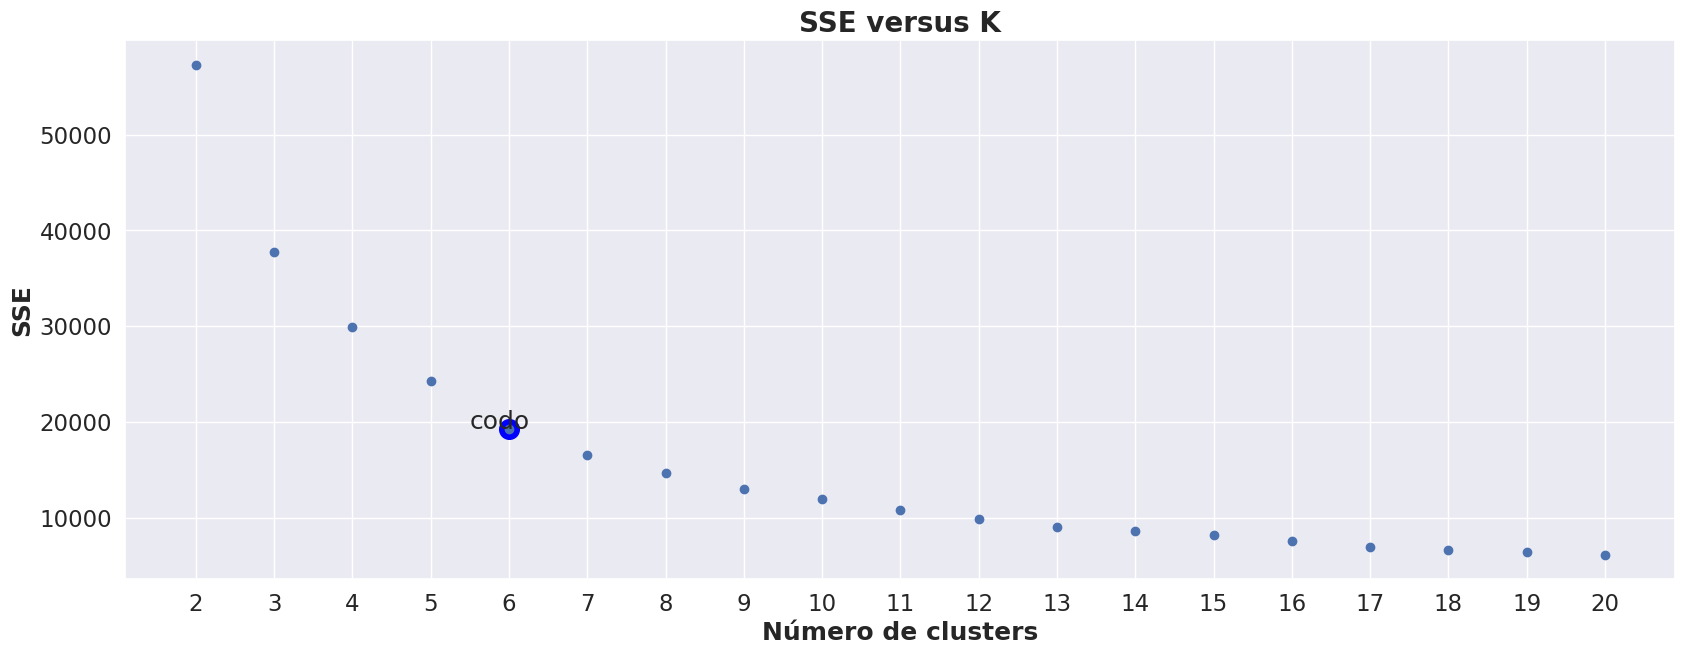

In [119]:
sse = []
for k in range(2, 21):
  kkmeans = KMeans(n_clusters=k, n_init="auto", random_state = 29).fit(df_imputed)
  sse.append(kkmeans.inertia_)
kl = KneeLocator(range(2, 21), sse, curve="convex", direction="decreasing")

print("El codo está en k =", kl.elbow)
print("El SSE =", kl.all_elbows_y)

fig, ax = plt.subplots(figsize = (20, 7))

# estas dos lineas se agregan para que se vea la elección de KneeLocator para el codo en este gráfico
ax.scatter(kl.elbow, sse[kl.elbow-2], color='blue', s=200) # agrega un punto rojo al plot de tamaño s=200 en el lugar donde se encuentra el codo
ax.text(kl.elbow-.5, sse[kl.elbow-2]-25, s="codo")       # agrega un texto abajo para indicar qué representa el punto

# estas lineas son el grafico de SS vs K
ax.scatter(range(2, 21), sse)
ax.set_xticks(range(2, 21))
ax.set_xlabel("Número de clusters", fontsize=18, fontweight="bold")
ax.set_ylabel("SSE", fontsize=18, fontweight="bold")
plt.title("SSE versus K", fontsize=20, fontweight="bold")
plt.show()

### Creación y entrenamiento del modelo

In [120]:
kmeans_x= KMeans(n_clusters=kl.elbow, n_init=10, random_state = 29)
grupos = kmeans_x.fit_predict(df_imputed)
df_main['grupo'] = grupos

In [121]:
silhouette_simple= silhouette_score(df_imputed, grupos)
print(f"Silhouette Score (espacio seleccionado): {silhouette_simple:.4f}")

Silhouette Score (espacio seleccionado): 0.4324


El agrupamiento que evalua el silhouette nos indica que tiene una estructura moderadamente buena.

### Evaluación del modelo

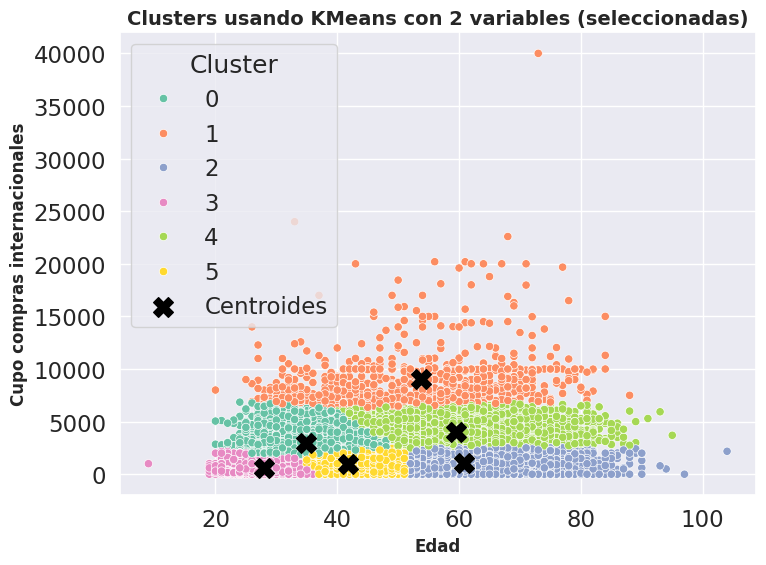

In [122]:
centroides_escalados = kmeans_x.cluster_centers_
centroides_originales = scaler.inverse_transform(centroides_escalados)

# Gráfica de los grupos
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_main, x='Edad', y='CUPO_MX', hue='grupo', palette='Set2')
plt.scatter(centroides_originales[:, 0], centroides_originales[:, 1],
            s=200, c='black', marker='X', label='Centroides')
plt.title("Clusters usando KMeans con 2 variables (seleccionadas)", fontsize=14, fontweight="bold")
plt.xlabel("Edad", fontsize=12, fontweight="bold")
plt.ylabel("Cupo compras internacionales", fontsize=12, fontweight="bold")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

En este gráfico se aprecian 5+1 grupos (o clusters), gracias a que anteriormente se escogió a que ese era el número óptimo.

In [123]:
df_centroides = pd.DataFrame(centroides_originales, columns=['Edad', 'Cupo tarjeta'])
df_centroides['cluster'] = range(kl.elbow)
print(df_centroides)

        Edad  Cupo tarjeta  cluster
0  34.836110   2974.586523        0
1  53.746770   9049.394057        1
2  60.873165   1065.856467        2
3  27.990146    575.965398        3
4  59.462551   4011.102692        4
5  41.838835    974.975855        5


En este caso, se aprecia más fácilmente los grupos. Se puede observar que el cluster 0 agrupa a los de Edad promedio de 34, que tienen un promedio de $2974 pesos en su cupo de tarjeta. Este cluster también se aprecia en el gráfico como puntos de color "verde agua". Y así también se aprecian los demás. Donde el que más cupo tiene, son los del grupo 1, con 9049 pesos aproximadamente.

-------------------------------------------------------
Porcentaje de varianza explicada por cada componente
-------------------------------------------------------
[0.67641224 0.32358776]


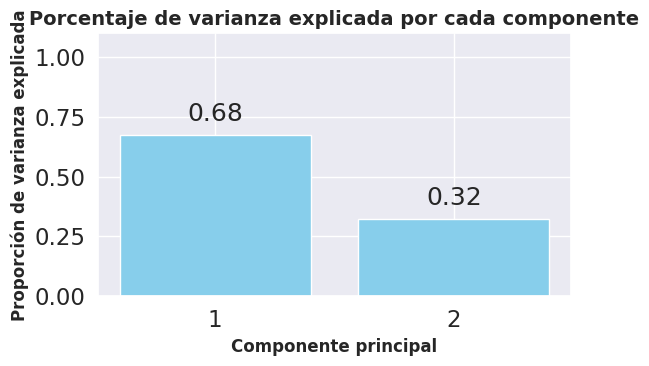

In [124]:
pca = PCA(n_components=2)
pca.fit(df_imputed)

print('-'*55)
print('Porcentaje de varianza explicada por cada componente')
print('-'*55)
print(pca.explained_variance_ratio_)

# Nombres de las variables originales para el gráfico
features = ['Edad', 'CUPO_MX']

# Gráfico de varianza explicada
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x=np.arange(pca.n_components_) + 1,
    height=pca.explained_variance_ratio_,
    color='skyblue'
)

for x, y in zip(np.arange(len(features)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente', fontsize=14, fontweight="bold")
ax.set_xlabel('Componente principal', fontsize=12, fontweight="bold")
ax.set_ylabel('Proporción de varianza explicada', fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

El primero componente "Edad", explica el 68% de la variabilidad.

El segundo componente explica el 32%

## Modelo de segmentación usando 4 o más variables

### Selección de las variables

In [125]:
df_pca = df_main[['Edad', 'Fac_T12', 'UsoL1_T12', 'Txs_T12']].copy()

scaler = StandardScaler()
df_escalado = scaler.fit_transform(df_pca)

imputer = KNNImputer(n_neighbors=3)
df_final = imputer.fit_transform(df_escalado)

df_final = pd.DataFrame(df_final, columns=df_pca.columns)

### Selección de número de clusters óptimo

El codo está en k = 7
El SSE = [np.float64(61446.86033162337)]


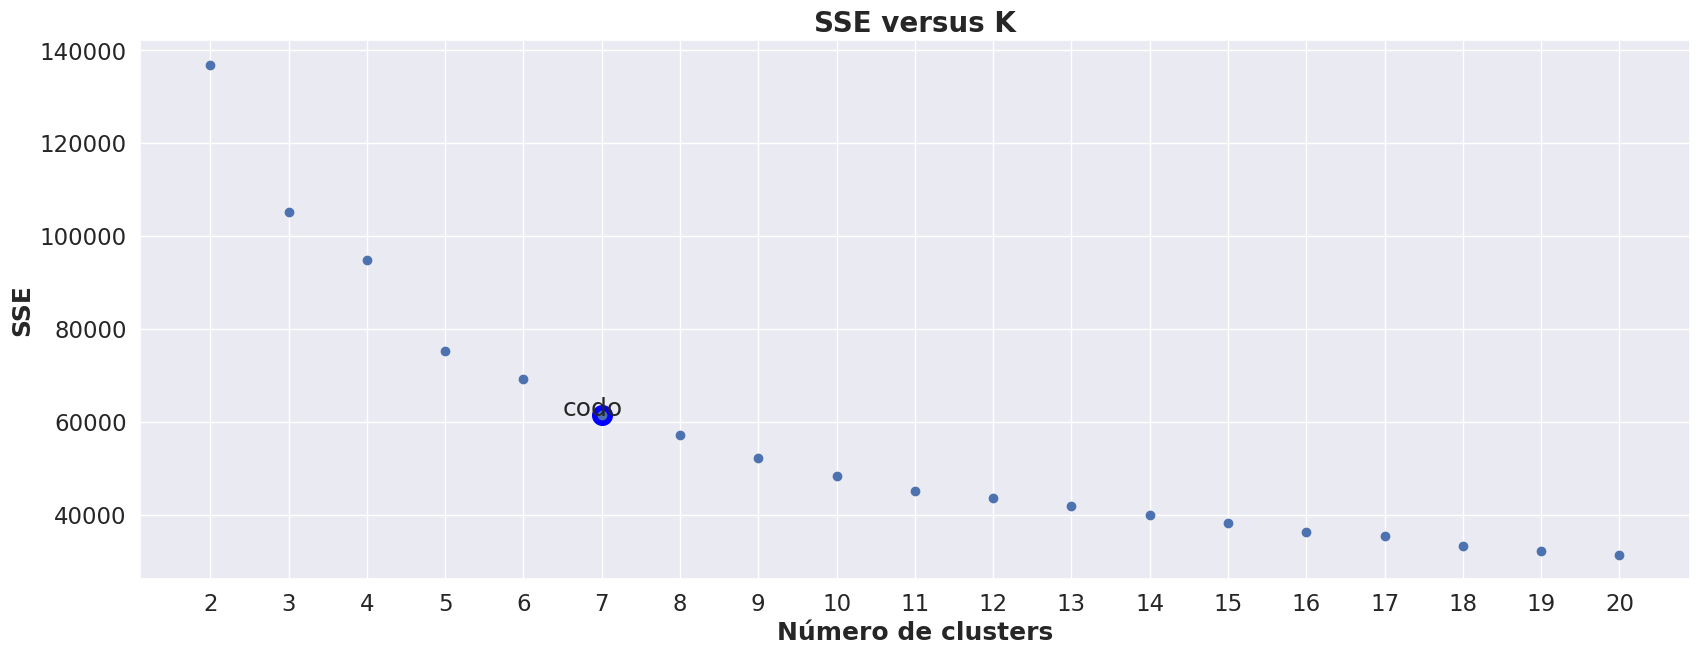

In [126]:
sse = []
for k in range(2, 21):
  kkmeans = KMeans(n_clusters=k, n_init="auto", random_state = 29).fit(df_final)
  sse.append(kkmeans.inertia_)

kl = KneeLocator(range(2, 21), sse, curve="convex", direction="decreasing")

print("El codo está en k =", kl.elbow)
print("El SSE =", kl.all_elbows_y)

# Gráfico

fig, ax = plt.subplots(figsize = (20, 7))

# estas dos lineas se agregan para que se vea la elección de KneeLocator para el codo en este gráfico
ax.scatter(kl.elbow, sse[kl.elbow-2], color='blue', s=200) # agrega un punto rojo al plot de tamaño s=200 en el lugar donde se encuentra el codo
ax.text(kl.elbow-.5, sse[kl.elbow-2]-50, s="codo")       # agrega un texto abajo para indicar qué representa el punto

# estas lineas son el grafico de SS vs K
ax.scatter(range(2, 21), sse)
ax.set_xticks(range(2, 21))
ax.set_xlabel("Número de clusters", fontsize=18, fontweight="bold")
ax.set_ylabel("SSE", fontsize=18, fontweight="bold")
plt.title("SSE versus K", fontsize=20, fontweight="bold")
plt.show()

### Creación y entrenamiento del modelo

In [127]:
kmeans_inicial = KMeans(n_clusters=kl.elbow, n_init=10, random_state = 29)
grupos_pca = kmeans_inicial.fit_predict(df_final)
df_main['grupo_pca'] = grupos_pca

silhouette_orig = silhouette_score(df_final, grupos_pca)
print(f"Silhouette Score (espacio original): {silhouette_orig:.4f}")

Silhouette Score (espacio original): 0.3107


Este resultado sugiere que existe cierta estructura de agrupamiento, aunque no completamente definida.

### Evaluación del modelo

In [128]:
centroides_all = kmeans_inicial.cluster_centers_
centroides_all_originales = scaler.inverse_transform(centroides_all)
df_all_centroides = pd.DataFrame(centroides_all_originales, columns=df_pca.columns)
df_all_centroides['cluster'] = range(kl.elbow)
print(df_all_centroides)

        Edad        Fac_T12     UsoL1_T12    Txs_T12  cluster
0  62.563118   63612.124406  1.417422e+05   2.502173        0
1  45.848947  246293.679592  3.078238e+05  13.974899        1
2  46.691031   56169.625549  1.131239e+06   2.230493        2
3  28.299529   24309.121273  4.377865e+04   1.181271        3
4  43.708995  761136.897613  3.413536e+05   5.827160        4
5  43.382579   22048.455927  1.622975e+05   0.996723        5
6  34.074232  133437.628292  1.368013e+05   4.874271        6


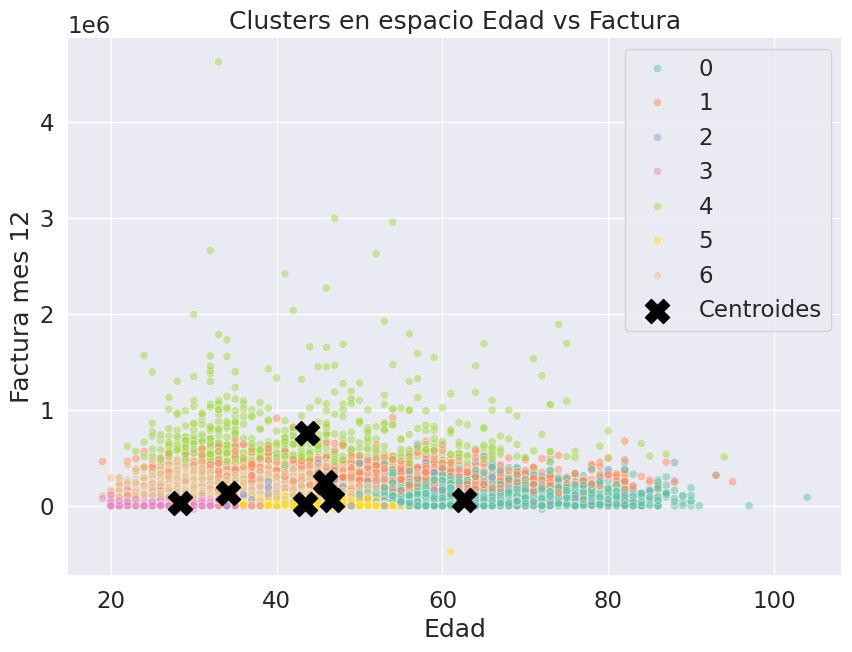

In [129]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_main, x='Edad', y='Fac_T12', hue='grupo_pca', palette='Set2', alpha=0.5)
plt.scatter(df_all_centroides['Edad'], df_all_centroides['Fac_T12'], s=300, c='black', marker='X', label='Centroides')
plt.title('Clusters en espacio Edad vs Factura')
plt.xlabel('Edad')
plt.ylabel('Factura mes 12')
plt.legend()
plt.show()

En este gráfico se aprecian los 6+1 grupos. Donde el cluster o nos marca donde están las personas de 62 años de edad en promedio, el monto que facturaron en el mes 12 clp 63.212 pesos en promedio, el monto de deuda en línea de compras en la tarjeta de crédito en el mes 12 de $141,742 pesos en promedio. Y por último, el número de transacciones realizadas, en este caso: 2 en promedio. Este cluster 0 se observa de color "verde agua". Y así también se pueden apreciar los demás clusters.

Tambien se pueden apreciar cosas como el que más monto promedio facturan están en el cluster 4 con 761.136 pesos. O que el grupo 1 son los que más transacciones realizan con 14 aproximadamente.

### Aplicación de PCA


Varianza explicada por cada componente:
Componente 1: 0.4153  |  Acumulada: 0.4153
Componente 2: 0.2782  |  Acumulada: 0.6935
Componente 3: 0.1962  |  Acumulada: 0.8897
Componente 4: 0.1103  |  Acumulada: 1.0000


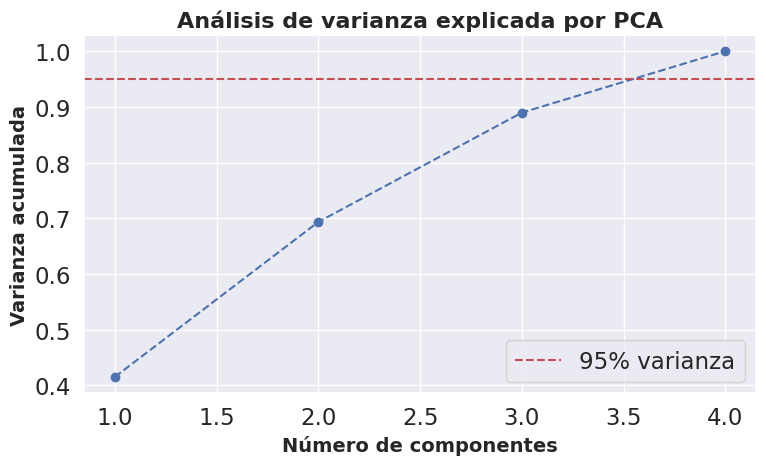


Número de componentes que explican >=95% de la varianza: 4


In [130]:
pca_full = PCA()
X_pca_full = pca_full.fit_transform(df_final)

# Varianza explicada por cada componente
var_exp = pca_full.explained_variance_ratio_
var_exp_acumulada = np.cumsum(var_exp)

# Mostrar tabla con varianza explicada
print("\nVarianza explicada por cada componente:")
for i, (v_ind, v_acum) in enumerate(zip(var_exp, var_exp_acumulada), 1):
    print(f"Componente {i}: {v_ind:.4f}  |  Acumulada: {v_acum:.4f}")

# Visualizar varianza acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(var_exp) + 1), var_exp_acumulada, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
plt.xlabel('Número de componentes', fontsize=14, fontweight="bold")
plt.ylabel('Varianza acumulada', fontsize=14, fontweight="bold")
plt.title('Análisis de varianza explicada por PCA', fontsize=16, fontweight="bold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Elegir número óptimo de componentes (>= 95% varianza)
n_componentes_optimos = np.argmax(var_exp_acumulada >= 0.95) + 1
print(f"\nNúmero de componentes que explican >=95% de la varianza: {n_componentes_optimos}")

In [131]:
pca = PCA(n_components=n_componentes_optimos)
X_pca = pca.fit_transform(df_final)

Silhouette Score (espacio PCA): 0.3107


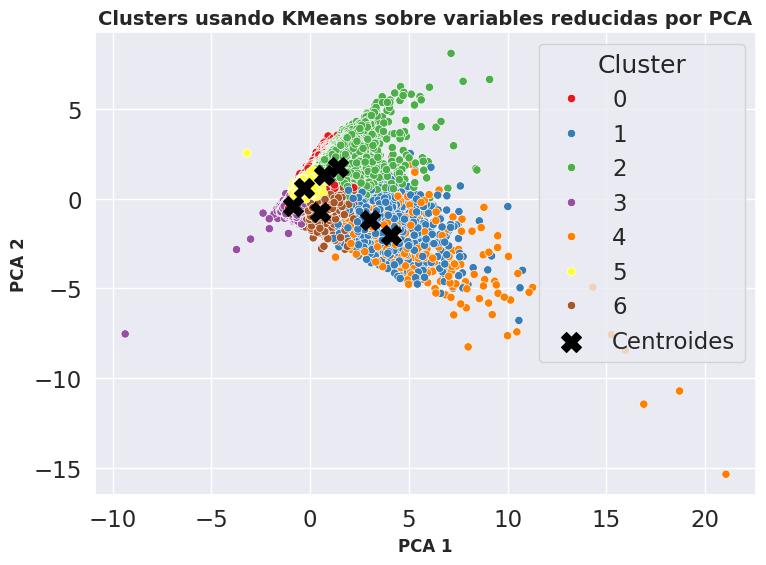

Porcentaje de varianza explicada por PCA: [0.41531761 0.27815977 0.19622406 0.11029857]
Centroides en espacio original:
 [[ 1.79367345 -0.02972824 -0.08365244 -0.02260322]
 [ 0.53719963  1.43368542  0.46369344  3.03988718]
 [ 0.60050264 -0.08934814  3.17737559 -0.09512453]
 [-0.78206314 -0.34457422 -0.40650533 -0.37520033]
 [ 0.37633053  5.5579584   0.5741958   0.86495757]
 [ 0.35179251 -0.36268381 -0.01590935 -0.42446284]
 [-0.34795471  0.52962542 -0.09993564  0.61059652]]
Centroides en espacio PCA:
 [[ 0.69855043  1.31006749 -1.00834187  0.02160646]
 [ 3.01815745 -1.18074205 -0.29060263 -1.11807876]
 [ 1.40618683  1.75816739  2.36279228 -0.00458645]
 [-0.88901575 -0.43750753  0.16967042  0.01879365]
 [ 4.1032491  -2.04599669 -0.23106799  3.3370758 ]
 [-0.30198346  0.57113338 -0.10946656  0.05147012]
 [ 0.49075267 -0.73528081  0.02530585 -0.05321036]]


In [132]:
# KMeans sobre las componentes principales
kmeans_pca = KMeans(n_clusters=kl.elbow, n_init=10, random_state=29)
clusters_pca = kmeans_pca.fit_predict(X_pca)

# Visualización del resultado de aplicar KMeans sobre PCA
df_main['cluster_pca'] = clusters_pca

silhouette_pca = silhouette_score(X_pca, clusters_pca)
print(f"Silhouette Score (espacio PCA): {silhouette_pca:.4f}")

# Obtener los centroides en el espacio PCA
centroides_pca = kmeans_pca.cluster_centers_

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters_pca, palette='Set1')
plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1],
            s=200, c='black', marker='X', label='Centroides')
plt.title("Clusters usando KMeans sobre variables reducidas por PCA", fontsize=14, fontweight="bold")
plt.xlabel("PCA 1", fontsize=12, fontweight="bold")
plt.ylabel("PCA 2", fontsize=12, fontweight="bold")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Comparación ---
print("Porcentaje de varianza explicada por PCA:", pca.explained_variance_ratio_)
print("Centroides en espacio original:\n", kmeans_inicial.cluster_centers_)
print("Centroides en espacio PCA:\n", kmeans_pca.cluster_centers_)


Se aplicó PCA para reducir la dimensionalidad del conjunto de datos a cuatro componentes.

Además, el Porcentaje de varianza explicada por PCA: [0.41531761 0.27815977 0.19622406 0.11029857], nos indica que con 4 componentes principales se está reteniendo el 100% de la varianza, por lo tanto, no se pierde información relevante al aplicar PCA.

Por otro lado, el silhouette, es practicamente el mismo, por lo que sigue existiendo cierta estructura de agrupamiento, aunque no completamente definida.